# 🎓 Capstone Project - Advanced Machine Learning
## TEC-VIII Programa de Especialización en Big Data Analytics aplicada a los Negocios

---

### 📋 Información del Proyecto

| Campo | Información |
|-------|-------------|
| **Nombre del Estudiante** | Vladimir Alberto Yuyes Benites |
| **Título del Proyecto** | Modelado Predictivo de Series Temporales de Ventas
| **Fecha de Entrega** | 19/02/2026 |
| **Profesor** | Carlos Antonio Mariño del Rosario |

---

## 📑 Índice

1. [Resumen Ejecutivo](#1-resumen-ejecutivo)
2. [Configuración del Entorno](#2-configuración-del-entorno)
3. [Definición del Problema de Negocio](#3-definición-del-problema-de-negocio)
4. [Carga y Exploración de Datos](#4-carga-y-exploración-de-datos)
5. [Preprocesamiento de Datos](#5-preprocesamiento-de-datos)
6. [Diseño y Arquitectura del Modelo](#6-diseño-y-arquitectura-del-modelo)
7. [Entrenamiento del Modelo](#7-entrenamiento-del-modelo)
8. [Evaluación y Métricas](#8-evaluación-y-métricas)
9. [Interpretación de Resultados](#9-interpretación-de-resultados)
10. [Conclusiones y Recomendaciones de Negocio](#10-conclusiones-y-recomendaciones-de-negocio)
11. [Referencias](#11-referencias)

---
## 1. Resumen Ejecutivo

**Instrucciones:** Proporcione un resumen conciso (máximo 300 palabras) que incluya:
- Problema de negocio abordado
- Metodología utilizada
- Principales hallazgos
- Impacto esperado en el negocio

---

El presente proyecto aborda el desafío del pronóstico de ventas en empresas de consumo masivo, un aspecto clave para la planificación de demanda, producción y gestión de inventarios en compañías como Sigma Alimentos. En este tipo de industrias, estimar incorrectamente la demanda puede generar quiebres de stock, sobreinventarios o mayores costos logísticos, afectando tanto la rentabilidad como el nivel de servicio al cliente.

Para desarrollar el análisis se utilizó un dataset público de Kaggle como referencia, el cual contiene información histórica de ventas en el sector retail. A partir de estos datos, se construyó una serie temporal diaria que permitió simular un escenario real de planificación comercial. El objetivo fue predecir ventas futuras en función del comportamiento pasado, replicando un problema típico de forecast en consumo masivo.

Se evaluaron dos enfoques: uno basado en un modelo predictivo tradicional ampliamente usado en análisis de datos (XGBoost) y otro basado en redes neuronales (LSTM), que permite capturar patrones más complejos en el tiempo. Ambos modelos fueron comparados utilizando métricas de error para determinar cuál ofrece mayor precisión en el pronóstico.

Los resultados muestran que es posible mejorar la calidad de las proyecciones utilizando modelos avanzados, lo que en un entorno real puede traducirse en decisiones más acertadas de producción, abastecimiento y reposición. En términos de negocio, incluso pequeñas mejoras en la precisión del forecast pueden generar impactos relevantes en eficiencia operativa y reducción de costos, fortaleciendo el proceso de planificación en empresas de consumo masivo.

---

## 2. Configuración del Entorno

### 2.1 Verificación de GPU (Recomendado para Deep Learning)

In [ ]:
# Verificar si hay GPU disponible
import torch

# Verificar disponibilidad de GPU
if torch.cuda.is_available():
    print(f"✅ GPU disponible: {torch.cuda.get_device_name(0)}")
    print(f"   Memoria GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    device = torch.device('cuda')
else:
    print("⚠️ GPU no disponible. Usando CPU.")
    print("   Recomendación: En Colab, vaya a Runtime > Change runtime type > GPU")
    device = torch.device('cpu')

print(f"\nDispositivo seleccionado: {device}")

⚠️ GPU no disponible. Usando CPU.
   Recomendación: En Colab, vaya a Runtime > Change runtime type > GPU

Dispositivo seleccionado: cpu


### 2.2 Instalación de Librerías Adicionales (si es necesario)

In [ ]:
# Descomente e instale las librerías adicionales que necesite
# !pip install transformers
# !pip install pytorch-lightning
# !pip install optuna
# !pip install shap
# !pip install lime

### 2.3 Importación de Librerías

In [ ]:
# =====================================================
# LIBRERÍAS FUNDAMENTALES
# =====================================================

# Manipulación de datos
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning - PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

# Deep Learning - TensorFlow/Keras (alternativa)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks

# Preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             mean_squared_error, mean_absolute_error, r2_score)

# Utilidades
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
%matplotlib inline

# Semilla para reproducibilidad
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print("✅ Todas las librerías importadas correctamente")
print(f"   PyTorch version: {torch.__version__}")
print(f"   TensorFlow version: {tf.__version__}")

✅ Todas las librerías importadas correctamente
   PyTorch version: 2.9.0+cpu
   TensorFlow version: 2.19.0


### 2.4 Conexión con Google Drive (para cargar datos)

In [ ]:
# Montar Google Drive para acceder a los datos
from google.colab import drive
drive.mount('/content/drive')

# Definir la ruta base de su proyecto
# Modifique esta ruta según la ubicación de sus datos
BASE_PATH = '/content/drive/MyDrive/Capstone_Project/'

print(f"✅ Google Drive montado")
print(f"   Ruta base del proyecto: {BASE_PATH}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive montado
   Ruta base del proyecto: /content/drive/MyDrive/Capstone_Project/


---
## 3. Definición del Problema de Negocio

### 3.1 Contexto del Negocio

**Instrucciones:** Describa el contexto empresarial, incluyendo:
- Industria/Sector
- Empresa o caso de estudio
- Situación actual

---

El sector de consumo masivo se caracteriza por altos volúmenes de venta, múltiples puntos de distribución y una demanda que puede variar según estacionalidad, promociones y comportamiento del consumidor. Empresas como Sigma Alimentos operan en entornos donde la planificación de producción y abastecimiento depende en gran medida de la precisión del pronóstico de ventas.

En la situación actual, muchas decisiones operativas se apoyan en modelos históricos o proyecciones tradicionales que no siempre capturan cambios en patrones de consumo. Esto puede generar desviaciones entre lo planificado y lo realmente demandado, afectando inventarios, costos logísticos y niveles de servicio.

Para este proyecto se utilizó un dataset público de ventas retail como referencia, simulando un escenario real de planificación de demanda en consumo masivo.

---

### 3.2 Problema a Resolver

**Instrucciones:** Defina claramente:
- ¿Cuál es el problema específico?
- ¿Por qué es importante resolverlo?
- ¿Cuál es el impacto actual del problema?

---

El problema específico es mejorar la precisión del pronóstico de ventas diarias a partir de datos históricos.

Resolver este problema es importante porque el forecast es la base para decisiones de producción, compras y distribución. Un error significativo puede generar sobrestock (incrementando costos financieros y de almacenamiento) o quiebres de inventario (impactando ventas y satisfacción del cliente).

Actualmente, la falta de modelos más robustos puede limitar la capacidad de anticiparse a cambios en la demanda, reduciendo la eficiencia operativa y afectando la rentabilidad.

---

### 3.3 Objetivos del Proyecto

**Instrucciones:** Liste los objetivos SMART (Específicos, Medibles, Alcanzables, Relevantes, Temporales)

---

**Objetivo General:**
Desarrollar y evaluar modelos predictivos que permitan mejorar la precisión del pronóstico de ventas diarias en un entorno de consumo masivo.

**Objetivos Específicos:**
1. Construir una serie temporal consolidada a partir de datos históricos de ventas.
2. Implementar y comparar un modelo basado en Machine Learning (XGBoost) y un modelo de Deep Learning (LSTM).
3. Evaluar el desempeño de los modelos utilizando métricas cuantitativas de error y determinar cuál ofrece mejores resultados para el forecast.

---

### 3.4 Tipo de Problema de Machine Learning

**Instrucciones:** Identifique el tipo de problema:
- [ ] Clasificación binaria
- [ ] Clasificación multiclase
- [X] Regresión
- [ ] Clustering
- [X] Series temporales
- [ ] Procesamiento de Lenguaje Natural (NLP)
- [ ] Visión por Computadora
- [ ] Otro: _________

**Justificación:**

El proyecto busca predecir un valor numérico continuo (ventas) en función de datos históricos organizados en el tiempo. Por ello, se trata de un problema de regresión aplicado a series temporales, donde el objetivo es estimar valores futuros basados en patrones pasados.

---

---
## 4. Carga y Exploración de Datos

### 4.1 Carga de Datos

In [22]:
# =====================================================
# CARGA DE DATOS
# =====================================================

# Opción 1: Cargar desde Google Drive
# df = pd.read_csv(BASE_PATH + 'datos.csv')

# Opción 2: Cargar desde URL
# df = pd.read_csv('https://url-de-sus-datos.com/datos.csv')

# Opción 3: Cargar desde archivo local (subido a Colab)
# from google.colab import files
# uploaded = files.upload()
# df = pd.read_csv('nombre_archivo.csv')

# Opción 4: Dataset de ejemplo (para testing)
# from sklearn.datasets import load_iris, load_boston, fetch_california_housing
# data = load_iris()
# df = pd.DataFrame(data.data, columns=data.feature_names)
# df['target'] = data.target

# =====================================================

# Ruta del archivo (ajusta si está en carpeta)
BASE_PATH = "/content/drive/MyDrive/"
df = pd.read_csv(BASE_PATH + "datos.csv")

# =====================================================
# Verificación
# =====================================================

print(f"✅ Dataset cargado exitosamente")
print(f"   Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")

df.head()

✅ Dataset cargado exitosamente
   Dimensiones: 937 filas × 4 columnas


,data,venda,estoque,preco
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


### 4.2 Descripción del Dataset

**Instrucciones:** Describa su dataset:
- Fuente de los datos

El dataset utilizado en este proyecto proviene de Kaggle y corresponde a un conjunto de datos de ventas minoristas (Retail Sales Forecasting). Se empleó como referencia metodológica para simular un escenario real de planificación de demanda en una empresa del sector de consumo masivo, como Sigma Alimentos.

- Período de tiempo que cubren

El dataset contiene registros diarios de ventas que cubren aproximadamente cinco años consecutivos. Esta extensión temporal permite capturar patrones de estacionalidad, tendencias y variaciones en el comportamiento de la demanda a lo largo del tiempo.

- Descripción de cada variable

---

| Variable | Tipo | Descripción |
|----------|------|-------------|
| data | Fecha | Fecha del registro de ventas. Permite estructurar el análisis como serie temporal |
| venda | Nùmerica | Cantidad vendida en la fecha correspondiente. Representa la demanda observada |
| stoque | Nùmerica | Nivel de inventario disponible en la fecha registrada. Puede influir en la capacidad de venta |
| preco | Nùmerica | Precio del producto en la fecha indicada. Puede impactar directamente en el comportamiento de la demanda |
| ... | ... | ... |
| venda | Nùmerica | Variable objetivo del modelo. Se busca predecir la cantidad vendida en períodos futuros a partir de información histórica. |

---

### 4.3 Exploración Inicial de Datos (EDA)

In [23]:
# =====================================================
# INFORMACIÓN GENERAL DEL DATASET
# =====================================================

print("=" * 60)
print("INFORMACIÓN GENERAL DEL DATASET")
print("=" * 60)

# Primeras filas
print("\n📊 Primeras 5 filas:")
display(df.head())

# Información del dataset
print("\n📋 Información del Dataset:")
print(df.info())

# Estadísticas descriptivas
print("\n📈 Estadísticas Descriptivas:")
display(df.describe())

INFORMACIÓN GENERAL DEL DATASET

📊 Primeras 5 filas:


,data,venda,estoque,preco
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29



📋 Información del Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     937 non-null    object 
 1   venda    937 non-null    int64  
 2   estoque  937 non-null    int64  
 3   preco    937 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 29.4+ KB
None

📈 Estadísticas Descriptivas:


,venda,estoque,preco
count,937.000000,937.000000,937.000000
mean,90.533618,1608.258271,1.592572
std,80.682089,1356.691877,0.529502
min,0.000000,0.000000,0.000000
25%,33.000000,794.000000,1.290000
50%,76.000000,1348.000000,1.390000
75%,127.000000,1964.000000,1.890000
max,542.000000,7228.000000,2.980000


In [24]:
# =====================================================
# ANÁLISIS DE VALORES FALTANTES
# =====================================================

print("=" * 60)
print("ANÁLISIS DE VALORES FALTANTES")
print("=" * 60)

# Calcular valores faltantes
missing_data = pd.DataFrame({
    'Total Faltantes': df.isnull().sum(),
    'Porcentaje (%)': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_data = missing_data[missing_data['Total Faltantes'] > 0].sort_values('Porcentaje (%)', ascending=False)

if len(missing_data) > 0:
    print("\n⚠️ Variables con valores faltantes:")
    display(missing_data)

    # Visualización de valores faltantes
    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing_data.index, y='Porcentaje (%)', data=missing_data)
    plt.title('Porcentaje de Valores Faltantes por Variable')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Porcentaje (%)')
    plt.tight_layout()
    plt.show()
else:
    print("\n✅ No hay valores faltantes en el dataset")

ANÁLISIS DE VALORES FALTANTES

✅ No hay valores faltantes en el dataset


ANÁLISIS DE LA VARIABLE OBJETIVO: venda

📊 Estadísticas de la variable objetivo:
count    937.000000
mean      90.533618
std       80.682089
min        0.000000
25%       33.000000
50%       76.000000
75%      127.000000
max      542.000000
Name: venda, dtype: float64


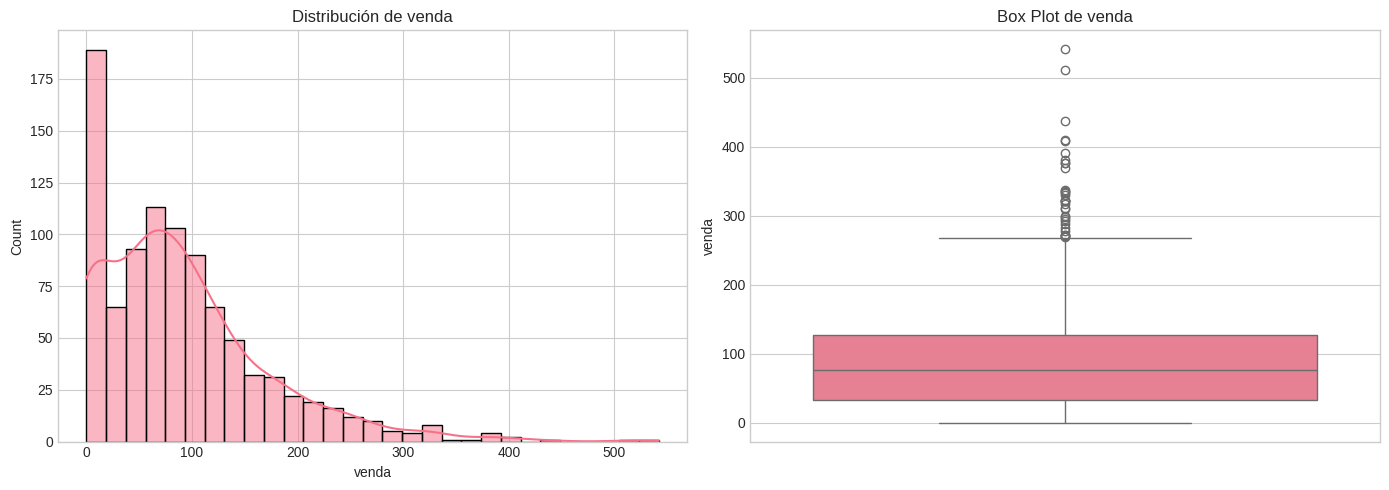

In [26]:
# =====================================================
# ANÁLISIS DE LA VARIABLE OBJETIVO
# =====================================================

# COMPLETE: Especifique el nombre de su variable objetivo
TARGET_COLUMN = 'venda'  # Cambie 'target' por el nombre de su variable objetivo

print("=" * 60)
print(f"ANÁLISIS DE LA VARIABLE OBJETIVO: {TARGET_COLUMN}")
print("=" * 60)

# Para clasificación
if df[TARGET_COLUMN].dtype == 'object' or df[TARGET_COLUMN].nunique() < 20:
    print("\n📊 Distribución de clases:")
    class_dist = df[TARGET_COLUMN].value_counts()
    print(class_dist)

    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Gráfico de barras
    sns.countplot(data=df, x=TARGET_COLUMN, ax=axes[0])
    axes[0].set_title(f'Distribución de {TARGET_COLUMN}')
    axes[0].set_xlabel(TARGET_COLUMN)
    axes[0].set_ylabel('Frecuencia')

    # Gráfico de pastel
    axes[1].pie(class_dist.values, labels=class_dist.index, autopct='%1.1f%%', startangle=90)
    axes[1].set_title(f'Proporción de {TARGET_COLUMN}')

    plt.tight_layout()
    plt.show()

    # Verificar desbalance
    imbalance_ratio = class_dist.max() / class_dist.min()
    if imbalance_ratio > 3:
        print(f"\n⚠️ ADVERTENCIA: Dataset desbalanceado (ratio {imbalance_ratio:.2f}:1)")
        print("   Considere técnicas de balanceo: SMOTE, undersampling, class weights")
else:
    # Para regresión
    print("\n📊 Estadísticas de la variable objetivo:")
    print(df[TARGET_COLUMN].describe())

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Histograma
    sns.histplot(df[TARGET_COLUMN], kde=True, ax=axes[0])
    axes[0].set_title(f'Distribución de {TARGET_COLUMN}')

    # Box plot
    sns.boxplot(y=df[TARGET_COLUMN], ax=axes[1])
    axes[1].set_title(f'Box Plot de {TARGET_COLUMN}')

    plt.tight_layout()
    plt.show()

MATRIZ DE CORRELACIONES


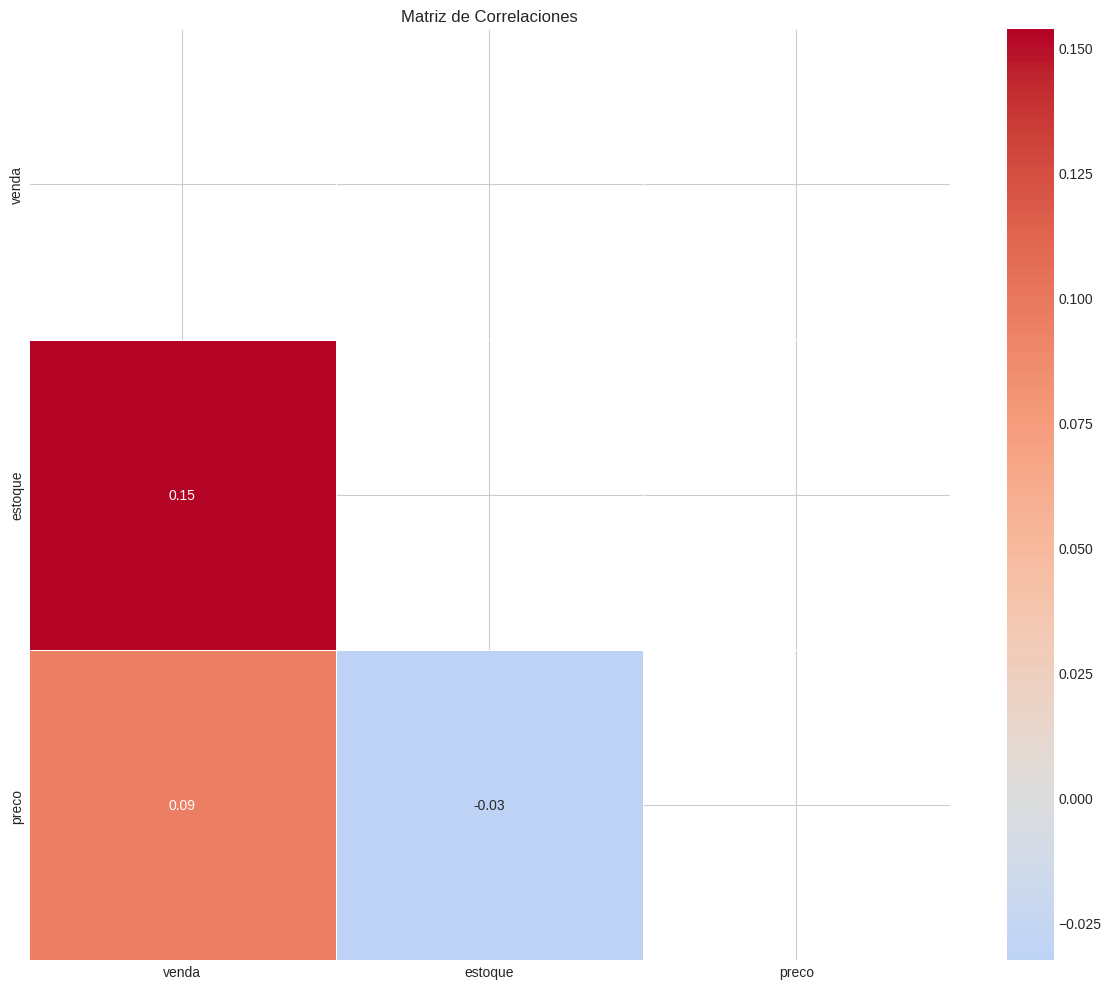


📊 Correlaciones con venda:
estoque    0.153659
preco      0.094779
Name: venda, dtype: float64


In [27]:
# =====================================================
# ANÁLISIS DE CORRELACIONES
# =====================================================

print("=" * 60)
print("MATRIZ DE CORRELACIONES")
print("=" * 60)

# Seleccionar solo columnas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns

if len(numeric_cols) > 1:
    # Calcular correlaciones
    correlation_matrix = df[numeric_cols].corr()

    # Visualización
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm',
                center=0, fmt='.2f', linewidths=0.5)
    plt.title('Matriz de Correlaciones')
    plt.tight_layout()
    plt.show()

    # Correlaciones con la variable objetivo
    if TARGET_COLUMN in numeric_cols:
        print(f"\n📊 Correlaciones con {TARGET_COLUMN}:")
        target_corr = correlation_matrix[TARGET_COLUMN].drop(TARGET_COLUMN).sort_values(ascending=False)
        print(target_corr)
else:
    print("⚠️ No hay suficientes columnas numéricas para análisis de correlación")

VISUALIZACIONES ADICIONALES


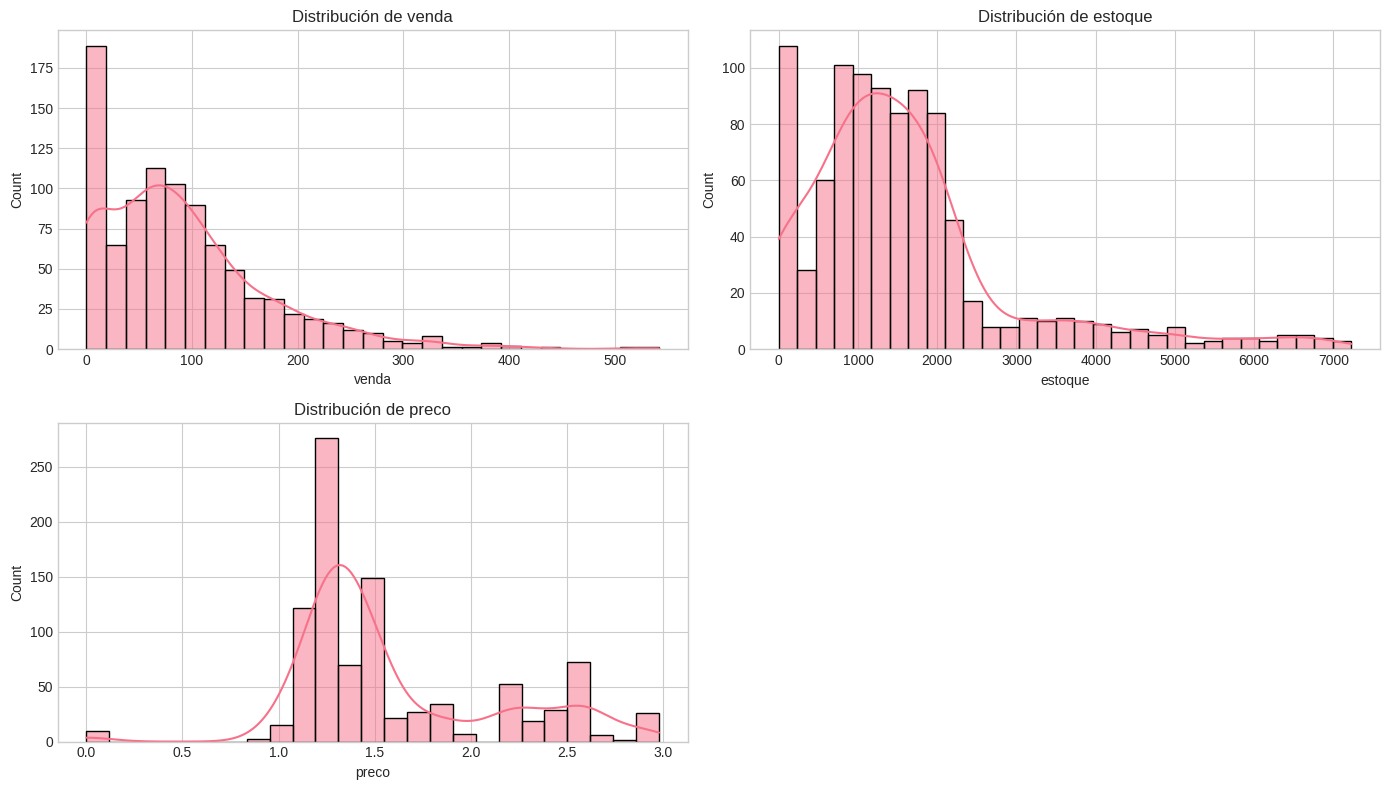

In [28]:
# =====================================================
# VISUALIZACIONES ADICIONALES
# =====================================================

print("=" * 60)
print("VISUALIZACIONES ADICIONALES")
print("=" * 60)

# Distribución de variables numéricas
numeric_cols_plot = df.select_dtypes(include=[np.number]).columns[:8]  # Primeras 8 columnas

if len(numeric_cols_plot) > 0:
    n_cols = 2
    n_rows = (len(numeric_cols_plot) + 1) // 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes]

    for i, col in enumerate(numeric_cols_plot):
        if i < len(axes):
            sns.histplot(df[col], kde=True, ax=axes[i])
            axes[i].set_title(f'Distribución de {col}')

    # Ocultar ejes vacíos
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

### 4.4 Hallazgos del EDA

**Instrucciones:** Resuma los principales hallazgos de la exploración de datos:

---

**Hallazgos Principales:**
1. La variable objetivo (venda) presenta una distribución asimétrica positiva, concentrando la mayoría de observaciones en niveles bajos y medios, con presencia de picos elevados de demanda.
2. Se identificaron valores atípicos en los niveles altos de venta, los cuales podrían estar asociados a eventos específicos como promociones o aumentos puntuales de consumo.
3. Las correlaciones lineales entre las variables (venda, preco, estoque) son bajas, lo que sugiere que el comportamiento de la demanda no depende únicamente de relaciones lineales simples, sino posiblemente de dinámicas temporales más complejas.

**Problemas Identificados:**
1. Presencia de valores extremos que podrían afectar la estabilidad de algunos modelos si no se gestionan adecuadamente.
2. Baja correlación lineal entre variables explicativas y la variable objetivo, lo que podría limitar el desempeño de modelos simples basados únicamente en relaciones lineales.

**Acciones a Tomar:**
1. Evaluar el uso de modelos robustos capaces de capturar relaciones no lineales y dependencias temporales, como XGBoost y redes LSTM.
2. Considerar la creación de variables derivadas temporales (mes, día de la semana, rezagos) para enriquecer el poder predictivo del modelo y capturar mejor los patrones de comportamiento en el tiempo.

---

---
## 5. Preprocesamiento de Datos

### 5.1 Tratamiento de Valores Faltantes

In [29]:
# =====================================================
# TRATAMIENTO DE VALORES FALTANTES
# =====================================================

print("=" * 60)
print("TRATAMIENTO DE VALORES FALTANTES")
print("=" * 60)

# Crear copia del dataframe
df_clean = df.copy()

# Opción 1: Eliminar filas con valores faltantes
# df_clean = df_clean.dropna()

# Opción 2: Imputar con la media (variables numéricas)
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy='mean')
# df_clean[numeric_cols] = imputer.fit_transform(df_clean[numeric_cols])

# Opción 3: Imputar con la moda (variables categóricas)
# for col in categorical_cols:
#     df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

# Opción 4: Imputación avanzada con KNN
# from sklearn.impute import KNNImputer
# imputer = KNNImputer(n_neighbors=5)
# df_clean[numeric_cols] = imputer.fit_transform(df_clean[numeric_cols])

# =====================================================
# COMPLETE AQUÍ: Aplique su estrategia de imputación
# =====================================================



print(f"\n✅ Valores faltantes tratados")
print(f"   Filas restantes: {len(df_clean):,}")

TRATAMIENTO DE VALORES FALTANTES

✅ Valores faltantes tratados
   Filas restantes: 937


### 5.2 Tratamiento de Outliers

In [30]:
# =====================================================
# DETECCIÓN Y TRATAMIENTO DE OUTLIERS
# =====================================================

print("=" * 60)
print("DETECCIÓN DE OUTLIERS")
print("=" * 60)

def detect_outliers_iqr(data, column):
    """Detecta outliers usando el método IQR"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return len(outliers), lower_bound, upper_bound

# Detectar outliers en cada columna numérica
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns

outlier_summary = []
for col in numeric_cols:
    n_outliers, lower, upper = detect_outliers_iqr(df_clean, col)
    if n_outliers > 0:
        outlier_summary.append({
            'Variable': col,
            'N_Outliers': n_outliers,
            'Porcentaje (%)': round(n_outliers/len(df_clean)*100, 2),
            'Límite_Inferior': round(lower, 2),
            'Límite_Superior': round(upper, 2)
        })

if outlier_summary:
    outlier_df = pd.DataFrame(outlier_summary)
    print("\n⚠️ Variables con outliers detectados:")
    display(outlier_df)
else:
    print("\n✅ No se detectaron outliers significativos")

DETECCIÓN DE OUTLIERS

⚠️ Variables con outliers detectados:


,Variable,N_Outliers,Porcentaje (%),Límite_Inferior,Límite_Superior
0,venda,34,3.63,-108.00,268.00
1,estoque,80,8.54,-961.00,3719.00
2,preco,37,3.95,0.39,2.79


In [31]:
# =====================================================
# TRATAMIENTO DE OUTLIERS (OPCIONAL)
# =====================================================

# Opción 1: Eliminar outliers
# for col in numeric_cols:
#     Q1, Q3 = df_clean[col].quantile([0.25, 0.75])
#     IQR = Q3 - Q1
#     df_clean = df_clean[(df_clean[col] >= Q1 - 1.5*IQR) & (df_clean[col] <= Q3 + 1.5*IQR)]

# Opción 2: Capear outliers (winsorizing)
# from scipy.stats import mstats
# for col in numeric_cols:
#     df_clean[col] = mstats.winsorize(df_clean[col], limits=[0.05, 0.05])

# Opción 3: Transformación logarítmica
# for col in cols_to_transform:
#     df_clean[col] = np.log1p(df_clean[col])

# =====================================================
# COMPLETE AQUÍ: Aplique su estrategia de tratamiento
# =====================================================




### 5.3 Codificación de Variables Categóricas

In [32]:
# =====================================================
# CODIFICACIÓN DE VARIABLES CATEGÓRICAS
# =====================================================

print("=" * 60)
print("CODIFICACIÓN DE VARIABLES CATEGÓRICAS")
print("=" * 60)

# Identificar variables categóricas
categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"\nVariables categóricas encontradas: {categorical_cols}")

# Opción 1: Label Encoding (para variables ordinales o target)
# le = LabelEncoder()
# df_clean['columna_encoded'] = le.fit_transform(df_clean['columna'])

# Opción 2: One-Hot Encoding (para variables nominales)
# df_clean = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

# Opción 3: Target Encoding
# from sklearn.preprocessing import TargetEncoder
# encoder = TargetEncoder()
# df_clean[categorical_cols] = encoder.fit_transform(df_clean[categorical_cols], df_clean[TARGET_COLUMN])

# =====================================================
# COMPLETE AQUÍ: Aplique su estrategia de codificación
# =====================================================



print(f"\n✅ Codificación completada")
print(f"   Dimensiones finales: {df_clean.shape}")

CODIFICACIÓN DE VARIABLES CATEGÓRICAS

Variables categóricas encontradas: ['data']

✅ Codificación completada
   Dimensiones finales: (937, 4)


=====================================================
FEATURE ENGINEERING
=====================================================

In [34]:
print("=" * 60)
print("FEATURE ENGINEERING - CREACIÓN DE VARIABLES TEMPORALES")
print("=" * 60)

# Asegurar formato fecha
df_clean['data'] = pd.to_datetime(df_clean['data'])

# Ordenar cronológicamente
df_clean = df_clean.sort_values('data')

# ==============================
# 1️⃣ Variables temporales
# ==============================

df_clean['year'] = df_clean['data'].dt.year
df_clean['month'] = df_clean['data'].dt.month
df_clean['day'] = df_clean['data'].dt.day
df_clean['dayofweek'] = df_clean['data'].dt.dayofweek
df_clean['weekofyear'] = df_clean['data'].dt.isocalendar().week.astype(int)
df_clean['is_weekend'] = df_clean['dayofweek'].isin([5,6]).astype(int)

print("✅ Variables temporales creadas")

# ==============================
# 2️⃣ Creación de Lags
# ==============================

df_clean['lag_1'] = df_clean['venda'].shift(1)
df_clean['lag_7'] = df_clean['venda'].shift(7)
df_clean['lag_30'] = df_clean['venda'].shift(30)

print("✅ Lags creados")

# ==============================
# 3️⃣ Promedios móviles
# ==============================

df_clean['rolling_7'] = df_clean['venda'].rolling(window=7).mean()
df_clean['rolling_30'] = df_clean['venda'].rolling(window=30).mean()

print("✅ Rolling means creados")

# ==============================
# 4️⃣ Eliminar nulos generados por lags
# ==============================

df_clean = df_clean.dropna()

print("✅ Valores nulos eliminados después de crear lags")
print(f"Nuevo tamaño del dataset: {df_clean.shape}")

df_clean.head()

FEATURE ENGINEERING - CREACIÓN DE VARIABLES TEMPORALES
✅ Variables temporales creadas
✅ Lags creados
✅ Rolling means creados
✅ Valores nulos eliminados después de crear lags
Nuevo tamaño del dataset: (907, 15)


,data,venda,estoque,preco,year,month,day,dayofweek,weekofyear,is_weekend,lag_1,lag_7,lag_30,rolling_7,rolling_30
30,2014-02-01,369,2145,0.99,2014,2,1,5,5,1,209.0,198.0,0.0,207.285714,145.133333
31,2014-02-02,217,1928,0.99,2014,2,2,6,5,1,369.0,168.0,70.0,214.285714,150.033333
32,2014-02-03,97,1831,0.99,2014,2,3,0,6,0,217.0,125.0,59.0,210.285714,151.300000
33,2014-02-04,117,1714,0.99,2014,2,4,1,6,0,97.0,86.0,93.0,214.714286,152.100000
34,2014-02-05,100,1998,1.29,2014,2,5,2,6,0,117.0,222.0,96.0,197.285714,152.233333


### 5.4 Escalado/Normalización de Features

In [35]:
# =====================================================
# ESCALADO DE FEATURES
# =====================================================

print("=" * 60)
print("ESCALADO DE FEATURES")
print("=" * 60)+

# Separar features y target
X = df_clean.drop(columns=[TARGET_COLUMN])
y = df_clean[TARGET_COLUMN]

print(f"\nDimensiones de X: {X.shape}")
print(f"Dimensiones de y: {y.shape}")

# Opción 1: StandardScaler (media=0, std=1) - Recomendado para redes neuronales
scaler = StandardScaler()

# Opción 2: MinMaxScaler (rango [0,1])
# scaler = MinMaxScaler()

# Opción 3: RobustScaler (robusto a outliers)
# from sklearn.preprocessing import RobustScaler
# scaler = RobustScaler()

# Aplicar escalado
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print(f"\n✅ Escalado completado usando {type(scaler).__name__}")
print(f"   Media de features: {X_scaled.mean().mean():.6f}")
print(f"   Std de features: {X_scaled.std().mean():.6f}")

SyntaxError: invalid syntax (ipython-input-682175454.py, line 7)

### 5.5 División de Datos (Train/Validation/Test)

In [ ]:
# =====================================================
# DIVISIÓN DE DATOS
# =====================================================

print("=" * 60)
print("DIVISIÓN DE DATOS")
print("=" * 60)

# División en train (70%), validation (15%), test (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.15, random_state=RANDOM_SEED, stratify=y if y.dtype == 'object' or y.nunique() < 20 else None
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=RANDOM_SEED, stratify=y_temp if y_temp.dtype == 'object' or y_temp.nunique() < 20 else None  # 0.176 ≈ 15% del total
)

print(f"\n📊 División de datos:")
print(f"   Training set:   {X_train.shape[0]:,} muestras ({X_train.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"   Validation set: {X_val.shape[0]:,} muestras ({X_val.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"   Test set:       {X_test.shape[0]:,} muestras ({X_test.shape[0]/len(X_scaled)*100:.1f}%)")

# Verificar distribución de clases (para clasificación)
if y.dtype == 'object' or y.nunique() < 20:
    print(f"\n📊 Distribución de clases en cada conjunto:")
    print(f"   Train: {dict(y_train.value_counts(normalize=True).round(3))}")
    print(f"   Val:   {dict(y_val.value_counts(normalize=True).round(3))}")
    print(f"   Test:  {dict(y_test.value_counts(normalize=True).round(3))}")

### 5.6 Preparación de Datos para Deep Learning

In [ ]:
# =====================================================
# PREPARACIÓN PARA PYTORCH
# =====================================================

print("=" * 60)
print("PREPARACIÓN DE DATOS PARA PYTORCH")
print("=" * 60)

# Convertir a tensores de PyTorch
X_train_tensor = torch.FloatTensor(X_train.values)
X_val_tensor = torch.FloatTensor(X_val.values)
X_test_tensor = torch.FloatTensor(X_test.values)

# Para clasificación
if y.dtype == 'object' or y.nunique() < 20:
    # Codificar labels si es necesario
    if y_train.dtype == 'object':
        label_encoder = LabelEncoder()
        y_train_encoded = label_encoder.fit_transform(y_train)
        y_val_encoded = label_encoder.transform(y_val)
        y_test_encoded = label_encoder.transform(y_test)
    else:
        y_train_encoded = y_train.values
        y_val_encoded = y_val.values
        y_test_encoded = y_test.values

    y_train_tensor = torch.LongTensor(y_train_encoded)
    y_val_tensor = torch.LongTensor(y_val_encoded)
    y_test_tensor = torch.LongTensor(y_test_encoded)
else:
    # Para regresión
    y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1)
    y_val_tensor = torch.FloatTensor(y_val.values).unsqueeze(1)
    y_test_tensor = torch.FloatTensor(y_test.values).unsqueeze(1)

# Crear DataLoaders
BATCH_SIZE = 32  # Ajuste según su dataset

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\n✅ DataLoaders creados")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Batches de entrenamiento: {len(train_loader)}")
print(f"   Batches de validación: {len(val_loader)}")
print(f"   Batches de test: {len(test_loader)}")

In [ ]:
# =====================================================
# PREPARACIÓN PARA TENSORFLOW/KERAS (ALTERNATIVA)
# =====================================================

print("=" * 60)
print("PREPARACIÓN DE DATOS PARA TENSORFLOW/KERAS")
print("=" * 60)

# Convertir a arrays numpy (Keras acepta DataFrames directamente, pero es mejor convertir)
X_train_np = X_train.values.astype('float32')
X_val_np = X_val.values.astype('float32')
X_test_np = X_test.values.astype('float32')

# Para clasificación: One-hot encoding del target
if y.dtype == 'object' or y.nunique() < 20:
    num_classes = y.nunique()
    y_train_np = keras.utils.to_categorical(y_train_encoded, num_classes)
    y_val_np = keras.utils.to_categorical(y_val_encoded, num_classes)
    y_test_np = keras.utils.to_categorical(y_test_encoded, num_classes)
else:
    y_train_np = y_train.values.astype('float32')
    y_val_np = y_val.values.astype('float32')
    y_test_np = y_test.values.astype('float32')

print(f"\n✅ Datos preparados para TensorFlow/Keras")
print(f"   Shape X_train: {X_train_np.shape}")
print(f"   Shape y_train: {y_train_np.shape}")

---
## 6. Diseño y Arquitectura del Modelo

### 6.1 Justificación de la Arquitectura

**Instrucciones:** Justifique la elección de su arquitectura de red neuronal:
- ¿Por qué eligió este tipo de arquitectura?
- ¿Qué alternativas consideró?
- ¿Cómo determinó el número de capas y neuronas?

---

*[Escriba su justificación aquí]*



---

### 6.2 Definición del Modelo

In [ ]:
# =====================================================
# DEFINICIÓN DEL MODELO CON PYTORCH
# =====================================================

class NeuralNetwork(nn.Module):
    """
    Red Neuronal para [Clasificación/Regresión]

    Arquitectura:
    - Capa de entrada: [n_features] neuronas
    - Capas ocultas: [Describir]
    - Capa de salida: [n_outputs] neuronas
    """

    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.3):
        super(NeuralNetwork, self).__init__()

        layers = []
        prev_size = input_size

        # Capas ocultas
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size

        # Capa de salida
        layers.append(nn.Linear(prev_size, output_size))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# =====================================================
# CONFIGURACIÓN DEL MODELO
# =====================================================

INPUT_SIZE = X_train.shape[1]
HIDDEN_SIZES = [128, 64, 32]  # Ajuste según su problema
OUTPUT_SIZE = y.nunique() if (y.dtype == 'object' or y.nunique() < 20) else 1
DROPOUT_RATE = 0.3

# Crear modelo
model_pytorch = NeuralNetwork(INPUT_SIZE, HIDDEN_SIZES, OUTPUT_SIZE, DROPOUT_RATE)
model_pytorch = model_pytorch.to(device)

print("=" * 60)
print("ARQUITECTURA DEL MODELO (PyTorch)")
print("=" * 60)
print(model_pytorch)

# Contar parámetros
total_params = sum(p.numel() for p in model_pytorch.parameters())
trainable_params = sum(p.numel() for p in model_pytorch.parameters() if p.requires_grad)
print(f"\n📊 Parámetros totales: {total_params:,}")
print(f"   Parámetros entrenables: {trainable_params:,}")

In [ ]:
# =====================================================
# DEFINICIÓN DEL MODELO CON KERAS (ALTERNATIVA)
# =====================================================

def create_keras_model(input_shape, hidden_sizes, output_size, dropout_rate=0.3, task='classification'):
    """
    Crea un modelo de red neuronal con Keras.

    Args:
        input_shape: Dimensión de entrada
        hidden_sizes: Lista con el número de neuronas por capa oculta
        output_size: Número de neuronas de salida
        dropout_rate: Tasa de dropout
        task: 'classification' o 'regression'
    """
    model = keras.Sequential()

    # Capa de entrada
    model.add(layers.Input(shape=(input_shape,)))

    # Capas ocultas
    for hidden_size in hidden_sizes:
        model.add(layers.Dense(hidden_size))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.Dropout(dropout_rate))

    # Capa de salida
    if task == 'classification':
        if output_size == 2:
            model.add(layers.Dense(1, activation='sigmoid'))
        else:
            model.add(layers.Dense(output_size, activation='softmax'))
    else:
        model.add(layers.Dense(1, activation='linear'))

    return model

# Crear modelo Keras
TASK = 'classification'  # Cambie a 'regression' si es necesario

model_keras = create_keras_model(
    input_shape=INPUT_SIZE,
    hidden_sizes=HIDDEN_SIZES,
    output_size=OUTPUT_SIZE,
    dropout_rate=DROPOUT_RATE,
    task=TASK
)

print("=" * 60)
print("ARQUITECTURA DEL MODELO (Keras)")
print("=" * 60)
model_keras.summary()

### 6.3 Diagrama de la Arquitectura

**Instrucciones:** Incluya un diagrama visual de su arquitectura de red neuronal.

---

*[Inserte diagrama o descripción visual de la arquitectura]*

```
Input Layer          Hidden Layer 1       Hidden Layer 2       Output Layer
[n features]   -->   [128 neurons]   -->  [64 neurons]    -->  [n classes]
                     + BatchNorm          + BatchNorm
                     + ReLU               + ReLU
                     + Dropout(0.3)       + Dropout(0.3)
```

---

---
## 7. Entrenamiento del Modelo

### 7.1 Configuración del Entrenamiento

In [ ]:
# =====================================================
# HIPERPARÁMETROS DE ENTRENAMIENTO
# =====================================================

print("=" * 60)
print("CONFIGURACIÓN DEL ENTRENAMIENTO")
print("=" * 60)

# Hiperparámetros
LEARNING_RATE = 0.001
EPOCHS = 100
BATCH_SIZE = 32
EARLY_STOPPING_PATIENCE = 10

print(f"\n📋 Hiperparámetros:")
print(f"   Learning Rate: {LEARNING_RATE}")
print(f"   Epochs: {EPOCHS}")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Early Stopping Patience: {EARLY_STOPPING_PATIENCE}")

In [ ]:
# =====================================================
# CONFIGURACIÓN DE LOSS Y OPTIMIZADOR (PyTorch)
# =====================================================

# Seleccionar función de pérdida según el tipo de problema
if y.dtype == 'object' or y.nunique() < 20:
    # Clasificación
    criterion = nn.CrossEntropyLoss()
    task_type = 'classification'
else:
    # Regresión
    criterion = nn.MSELoss()
    task_type = 'regression'

# Optimizador
optimizer = optim.Adam(model_pytorch.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

print(f"\n📋 Configuración:")
print(f"   Tipo de problema: {task_type}")
print(f"   Función de pérdida: {criterion}")
print(f"   Optimizador: Adam")
print(f"   Scheduler: ReduceLROnPlateau")

### 7.2 Entrenamiento del Modelo (PyTorch)

In [ ]:
# =====================================================
# FUNCIONES DE ENTRENAMIENTO Y EVALUACIÓN
# =====================================================

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Entrena el modelo por una época."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if task_type == 'classification':
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total if task_type == 'classification' else None

    return avg_loss, accuracy

def evaluate(model, val_loader, criterion, device):
    """Evalúa el modelo en el conjunto de validación."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()

            if task_type == 'classification':
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()

    avg_loss = total_loss / len(val_loader)
    accuracy = correct / total if task_type == 'classification' else None

    return avg_loss, accuracy

In [ ]:
# =====================================================
# ENTRENAMIENTO DEL MODELO (PyTorch)
# =====================================================

print("=" * 60)
print("ENTRENAMIENTO DEL MODELO")
print("=" * 60)

# Historial de entrenamiento
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

# Early stopping
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

print(f"\n🚀 Iniciando entrenamiento...\n")

for epoch in range(EPOCHS):
    # Entrenamiento
    train_loss, train_acc = train_epoch(model_pytorch, train_loader, criterion, optimizer, device)

    # Validación
    val_loss, val_acc = evaluate(model_pytorch, val_loader, criterion, device)

    # Guardar historial
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    if task_type == 'classification':
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

    # Scheduler step
    scheduler.step(val_loss)

    # Imprimir progreso cada 10 épocas
    if (epoch + 1) % 10 == 0 or epoch == 0:
        if task_type == 'classification':
            print(f"Época {epoch+1:3d}/{EPOCHS} | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        else:
            print(f"Época {epoch+1:3d}/{EPOCHS} | "
                  f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model_pytorch.state_dict().copy()
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print(f"\n⚠️ Early stopping en época {epoch+1}")
            break

# Cargar mejor modelo
if best_model_state is not None:
    model_pytorch.load_state_dict(best_model_state)
    print(f"\n✅ Mejor modelo cargado (Val Loss: {best_val_loss:.4f})")

print(f"\n🎉 Entrenamiento completado!")

### 7.3 Entrenamiento del Modelo (Keras - Alternativa)

In [ ]:
# =====================================================
# ENTRENAMIENTO DEL MODELO (KERAS)
# =====================================================

# Compilar modelo
if TASK == 'classification':
    if OUTPUT_SIZE == 2:
        model_keras.compile(
            optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
    else:
        model_keras.compile(
            optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
else:
    model_keras.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='mse',
        metrics=['mae']
    )

# Callbacks
keras_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=EARLY_STOPPING_PATIENCE,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=0
    )
]

# Entrenar
print("=" * 60)
print("ENTRENAMIENTO DEL MODELO (KERAS)")
print("=" * 60)

history_keras = model_keras.fit(
    X_train_np, y_train_np,
    validation_data=(X_val_np, y_val_np),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=keras_callbacks,
    verbose=1
)

print("\n🎉 Entrenamiento completado!")

### 7.4 Visualización del Entrenamiento

In [ ]:
# =====================================================
# VISUALIZACIÓN DEL PROCESO DE ENTRENAMIENTO
# =====================================================

print("=" * 60)
print("CURVAS DE APRENDIZAJE")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de pérdida
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Evolución de la Pérdida', fontsize=14)
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gráfico de precisión (solo para clasificación)
if task_type == 'classification':
    axes[1].plot(history['train_acc'], label='Train Accuracy', linewidth=2)
    axes[1].plot(history['val_acc'], label='Validation Accuracy', linewidth=2)
    axes[1].set_title('Evolución de la Precisión', fontsize=14)
    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'N/A para Regresión', ha='center', va='center', fontsize=14)
    axes[1].set_title('Precisión (No aplica)')

plt.tight_layout()
plt.show()

# Análisis del entrenamiento
print("\n📊 Análisis del Entrenamiento:")
print(f"   Épocas completadas: {len(history['train_loss'])}")
print(f"   Mejor val_loss: {min(history['val_loss']):.4f} (época {history['val_loss'].index(min(history['val_loss']))+1})")
if task_type == 'classification':
    print(f"   Mejor val_acc: {max(history['val_acc']):.4f} (época {history['val_acc'].index(max(history['val_acc']))+1})")

---
## 8. Evaluación y Métricas

### 8.1 Evaluación en el Conjunto de Test

In [ ]:
# =====================================================
# EVALUACIÓN EN EL CONJUNTO DE TEST
# =====================================================

print("=" * 60)
print("EVALUACIÓN EN CONJUNTO DE TEST")
print("=" * 60)

# Hacer predicciones
model_pytorch.eval()
with torch.no_grad():
    X_test_device = X_test_tensor.to(device)
    outputs = model_pytorch(X_test_device)

    if task_type == 'classification':
        _, y_pred = torch.max(outputs, 1)
        y_pred = y_pred.cpu().numpy()
        y_true = y_test_tensor.numpy()
        y_proba = torch.softmax(outputs, dim=1).cpu().numpy()
    else:
        y_pred = outputs.cpu().numpy().flatten()
        y_true = y_test_tensor.numpy().flatten()

print(f"\n✅ Predicciones realizadas: {len(y_pred)} muestras")

In [ ]:
# =====================================================
# MÉTRICAS DE CLASIFICACIÓN
# =====================================================

if task_type == 'classification':
    print("=" * 60)
    print("MÉTRICAS DE CLASIFICACIÓN")
    print("=" * 60)

    # Calcular métricas
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"\n📊 Métricas Principales:")
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")

    # Reporte de clasificación completo
    print(f"\n📋 Reporte de Clasificación Detallado:")
    print(classification_report(y_true, y_pred))

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(OUTPUT_SIZE),
                yticklabels=range(OUTPUT_SIZE))
    plt.title('Matriz de Confusión', fontsize=14)
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.tight_layout()
    plt.show()

In [ ]:
# =====================================================
# MÉTRICAS DE REGRESIÓN
# =====================================================

if task_type == 'regression':
    print("=" * 60)
    print("MÉTRICAS DE REGRESIÓN")
    print("=" * 60)

    # Calcular métricas
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n📊 Métricas de Regresión:")
    print(f"   MSE:  {mse:.4f}")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   MAE:  {mae:.4f}")
    print(f"   R²:   {r2:.4f}")

    # Gráfico de predicciones vs valores reales
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Scatter plot
    axes[0].scatter(y_true, y_pred, alpha=0.5)
    axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[0].set_xlabel('Valor Real')
    axes[0].set_ylabel('Predicción')
    axes[0].set_title('Predicciones vs Valores Reales')

    # Distribución de residuos
    residuos = y_true - y_pred
    axes[1].hist(residuos, bins=50, edgecolor='black')
    axes[1].axvline(x=0, color='r', linestyle='--')
    axes[1].set_xlabel('Residuo')
    axes[1].set_ylabel('Frecuencia')
    axes[1].set_title('Distribución de Residuos')

    plt.tight_layout()
    plt.show()

### 8.2 Comparación con Modelo Baseline

In [ ]:
# =====================================================
# COMPARACIÓN CON MODELO BASELINE
# =====================================================

print("=" * 60)
print("COMPARACIÓN CON MODELO BASELINE")
print("=" * 60)

if task_type == 'classification':
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression

    # Modelos baseline
    baselines = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_SEED),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
    }
else:
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.linear_model import LinearRegression

    baselines = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)
    }

# Entrenar y evaluar baselines
results = {'Modelo': [], 'Métrica': []}

for name, model in baselines.items():
    model.fit(X_train, y_train)
    y_pred_baseline = model.predict(X_test)

    if task_type == 'classification':
        metric = accuracy_score(y_test, y_pred_baseline)
        metric_name = 'Accuracy'
    else:
        metric = r2_score(y_test, y_pred_baseline)
        metric_name = 'R²'

    results['Modelo'].append(name)
    results['Métrica'].append(metric)

# Agregar modelo de Deep Learning
results['Modelo'].append('Deep Learning')
if task_type == 'classification':
    results['Métrica'].append(accuracy)
else:
    results['Métrica'].append(r2)

# Mostrar comparación
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.sort_values('Métrica', ascending=False)

print(f"\n📊 Comparación de Modelos ({metric_name}):")
display(comparison_df)

# Visualización
plt.figure(figsize=(10, 6))
colors = ['#2ecc71' if m == 'Deep Learning' else '#3498db' for m in comparison_df['Modelo']]
plt.barh(comparison_df['Modelo'], comparison_df['Métrica'], color=colors)
plt.xlabel(metric_name)
plt.title(f'Comparación de Modelos - {metric_name}')
plt.tight_layout()
plt.show()

### 8.3 Análisis de Resultados

**Instrucciones:** Analice los resultados obtenidos:

---

**Rendimiento del Modelo:**
*[Analice las métricas obtenidas]*

**Comparación con Baselines:**
*[Compare el rendimiento con los modelos baseline]*

**Fortalezas del Modelo:**
1. *[Completar]*
2. *[Completar]*

**Debilidades del Modelo:**
1. *[Completar]*
2. *[Completar]*

**Posibles Mejoras:**
1. *[Completar]*
2. *[Completar]*

---

---
## 9. Interpretación de Resultados

### 9.1 Importancia de Features (SHAP)

In [ ]:
# =====================================================
# INTERPRETABILIDAD CON SHAP (OPCIONAL)
# =====================================================

# Instalar SHAP si no está disponible
# !pip install shap

try:
    import shap

    print("=" * 60)
    print("ANÁLISIS DE IMPORTANCIA DE FEATURES (SHAP)")
    print("=" * 60)

    # Crear explainer
    # Usar una muestra del dataset para acelerar el cálculo
    sample_size = min(100, len(X_test))
    X_sample = X_test.iloc[:sample_size]

    # Para modelos de sklearn (baselines)
    explainer = shap.TreeExplainer(baselines['Random Forest'])
    shap_values = explainer.shap_values(X_sample)

    # Visualización
    plt.figure(figsize=(12, 8))
    if task_type == 'classification' and len(shap_values) > 1:
        shap.summary_plot(shap_values[1], X_sample, plot_type="bar", show=False)
    else:
        shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
    plt.title('Importancia de Features (SHAP)')
    plt.tight_layout()
    plt.show()

except ImportError:
    print("⚠️ SHAP no está instalado. Ejecute: !pip install shap")
except Exception as e:
    print(f"⚠️ Error en análisis SHAP: {e}")

### 9.2 Interpretación de Negocios

**Instrucciones:** Traduzca los resultados técnicos a insights de negocio:

---

**Insights Principales:**
1. *[Insight 1 - ¿Qué significa el resultado para el negocio?]*
2. *[Insight 2]*
3. *[Insight 3]*

**Factores Más Importantes:**
*[¿Cuáles son los factores más importantes según el modelo y qué significan para el negocio?]*

**Patrones Identificados:**
*[¿Qué patrones ha identificado el modelo que pueden ser relevantes para la toma de decisiones?]*

---

---
## 10. Conclusiones y Recomendaciones de Negocio

### 10.1 Resumen de Resultados

**Instrucciones:** Proporcione un resumen ejecutivo de los resultados:

---

*[Resuma los principales resultados del proyecto en 2-3 párrafos]*

---

### 10.2 Conclusiones

**Instrucciones:** Liste las conclusiones principales:

---

1. *[Conclusión 1]*
2. *[Conclusión 2]*
3. *[Conclusión 3]*
4. *[Conclusión 4]*

---

### 10.3 Recomendaciones de Negocio

**Instrucciones:** Proporcione recomendaciones accionables basadas en los resultados:

---

**Recomendaciones a Corto Plazo:**
1. *[Recomendación 1]*
2. *[Recomendación 2]*

**Recomendaciones a Mediano Plazo:**
1. *[Recomendación 1]*
2. *[Recomendación 2]*

**Recomendaciones a Largo Plazo:**
1. *[Recomendación 1]*
2. *[Recomendación 2]*

---

### 10.4 Limitaciones del Estudio

**Instrucciones:** Identifique las limitaciones de su análisis:

---

1. *[Limitación 1]*
2. *[Limitación 2]*
3. *[Limitación 3]*

---

### 10.5 Trabajo Futuro

**Instrucciones:** Proponga líneas de investigación futura:

---

1. *[Propuesta 1]*
2. *[Propuesta 2]*
3. *[Propuesta 3]*

---

---
## 11. Referencias

**Instrucciones:** Liste todas las referencias utilizadas (formato APA):

---

1. *[Referencia 1]*
2. *[Referencia 2]*
3. *[Referencia 3]*

---

---
## Anexos

### A. Guardado del Modelo

In [ ]:
# =====================================================
# GUARDAR EL MODELO ENTRENADO
# =====================================================

print("=" * 60)
print("GUARDADO DEL MODELO")
print("=" * 60)

# Guardar modelo PyTorch
MODEL_PATH = 'modelo_final.pth'
torch.save({
    'model_state_dict': model_pytorch.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
    'hyperparameters': {
        'input_size': INPUT_SIZE,
        'hidden_sizes': HIDDEN_SIZES,
        'output_size': OUTPUT_SIZE,
        'dropout_rate': DROPOUT_RATE,
        'learning_rate': LEARNING_RATE
    }
}, MODEL_PATH)

print(f"\n✅ Modelo PyTorch guardado en: {MODEL_PATH}")

# Guardar modelo Keras (opcional)
# model_keras.save('modelo_final.keras')
# print(f"✅ Modelo Keras guardado en: modelo_final.keras")

# Guardar scaler
import joblib
joblib.dump(scaler, 'scaler.pkl')
print(f"✅ Scaler guardado en: scaler.pkl")

### B. Cargar Modelo Guardado (para Inferencia)

In [ ]:
# =====================================================
# CARGAR MODELO PARA INFERENCIA
# =====================================================

def load_model_and_predict(model_path, scaler_path, new_data):
    """
    Carga el modelo entrenado y hace predicciones sobre nuevos datos.

    Args:
        model_path: Ruta al archivo del modelo
        scaler_path: Ruta al archivo del scaler
        new_data: DataFrame con los nuevos datos

    Returns:
        Predicciones
    """
    # Cargar checkpoint
    checkpoint = torch.load(model_path, map_location=device)

    # Reconstruir modelo
    hp = checkpoint['hyperparameters']
    model = NeuralNetwork(
        hp['input_size'],
        hp['hidden_sizes'],
        hp['output_size'],
        hp['dropout_rate']
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    # Cargar scaler
    scaler = joblib.load(scaler_path)

    # Preprocesar datos
    new_data_scaled = scaler.transform(new_data)
    new_data_tensor = torch.FloatTensor(new_data_scaled).to(device)

    # Hacer predicción
    with torch.no_grad():
        outputs = model(new_data_tensor)
        if task_type == 'classification':
            _, predictions = torch.max(outputs, 1)
            predictions = predictions.cpu().numpy()
        else:
            predictions = outputs.cpu().numpy().flatten()

    return predictions

# Ejemplo de uso:
# predictions = load_model_and_predict('modelo_final.pth', 'scaler.pkl', new_df)
print("✅ Función de carga e inferencia definida")

---

## Checklist de Entrega

Antes de entregar, verifique que ha completado los siguientes elementos:

- [ ] Información del proyecto completada
- [ ] Resumen ejecutivo escrito
- [ ] Problema de negocio claramente definido
- [ ] Objetivos SMART establecidos
- [ ] EDA completo con visualizaciones
- [ ] Preprocesamiento de datos documentado
- [ ] Arquitectura del modelo justificada
- [ ] Modelo entrenado con curvas de aprendizaje
- [ ] Métricas de evaluación calculadas
- [ ] Comparación con modelos baseline
- [ ] Interpretación de resultados
- [ ] Conclusiones y recomendaciones de negocio
- [ ] Referencias listadas
- [ ] Código ejecutable sin errores
- [ ] Comentarios y documentación adecuados

---

**¡Buena suerte con su proyecto!** 🎓